# Dynamic Averaging Results: Simple NN

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from dyn_fed.utils.report_utils import generate_all_pivots, generate_packet_size_pivots
from dyn_fed.viz.report import plot_results, plot_pkt_size

rc('text', usetex=True)

In [3]:
project_dir = Path().resolve().parents[1]
project_dir

PosixPath('/Users/sashlinreddy/repos/masters/dyn-fed')

In [4]:
masters_dir = Path().resolve().parents[2]
masters_dir

PosixPath('/Users/sashlinreddy/repos/masters')

In [5]:
thesis_dir = (masters_dir/"fed-learn-thesis").resolve()
thesis_dir

PosixPath('/Users/sashlinreddy/repos/masters/fed-learn-thesis')

Join results

In [6]:
df1 = pd.read_csv(project_dir/"data/20200427-results.csv")
df2 = pd.read_csv(project_dir/"data/20200428-results.csv")
results = pd.concat([df1, df2]).reset_index(drop=True)

# Performance analysis

In [7]:
metrics = ['time', 'test_loss', 'test_acc', 'gen_gap', 'pkt_size', 'avg_comm_rate']

## MNIST - SGD

In [8]:
results = results.query('n_clients < 64')

In [9]:
results.shape

(1760, 21)

In [10]:
results.head()

,jobid,dataset,model_type,optimizer,n_clients,agg_mode,interval,comm_mode,noniid,unbalanced,...,epochs,delta_threshold,error,time,train_acc,test_acc,train_loss,test_loss,pkt_size,comm_rounds
0,60576,fashion-mnist,logistic,adam,32,1,1,0,0,1,...,100,NaN,0,130.226681,82.9133,82.11,1.5907,1.5992,92.919,3100.0
1,60577,mnist,logistic,sgd,24,1,20,0,0,0,...,100,NaN,0,20.272419,83.5967,84.42,1.7588,1.7534,3.447,115.0
2,60578,mnist,logistic,sgd,8,1,20,0,1,1,...,100,NaN,0,41.749354,67.8100,68.67,1.5134,1.8902,1.049,35.0
3,60579,fashion-mnist,cnn1,adam,24,1,1,1,1,1,...,50,NaN,0,342.623015,75.6150,74.52,1.5820,1.7204,1831.963,692.0
4,60580,fashion-mnist,cnn1,adam,24,1,1,2,1,0,...,50,NaN,1,NaN,12.1133,12.21,2.3042,2.3043,NaN,NaN


In [11]:
results.loc[:, "avg_comm_rate"] = results["comm_rounds"] / (results["n_clients"] - 1)

In [12]:
results.loc[:, "gen_gap"] = (results["test_loss"] - results["train_loss"]) / ((results["test_loss"] + results["train_loss"]))

In [13]:
results.loc[:, "delta_threshold"] = results.delta_threshold.fillna(0.0)

In [14]:
drop_query = "(delta_threshold <= 0.0 or delta_threshold > 2.0) and comm_mode == 3"
adam_results = results.copy()
results = results.drop(results.query(drop_query).index).reset_index(drop=True)

In [15]:
nn_mnist = results.query(
    "dataset == 'mnist' and model_type=='nn1' and n_clients < 64"
    " and optimizer == 'sgd'"
)
nn_fmnist = results.query(
    "dataset == 'fashion-mnist' and model_type=='nn1' and n_clients < 64"
    " and optimizer == 'sgd'"
)

In [16]:
mnist_res, mnist_q = generate_all_pivots(nn_mnist, metrics=metrics)

### Wall time

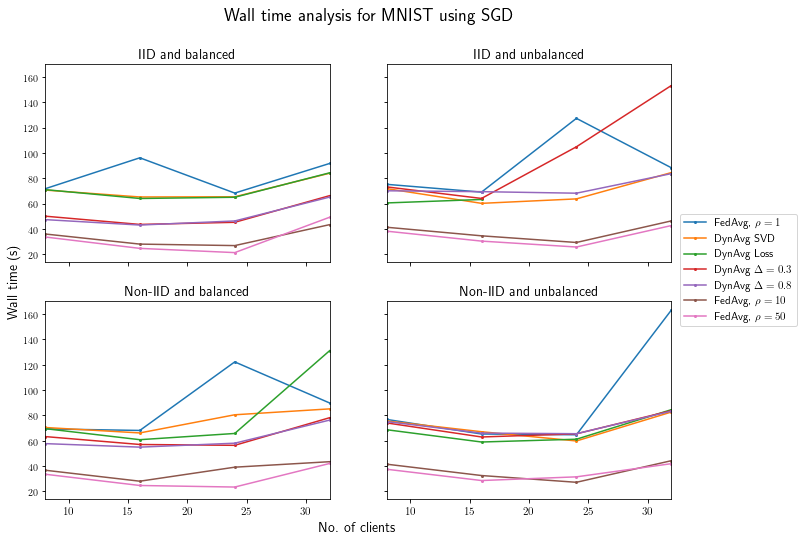

In [17]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    mnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle='Wall time analysis for MNIST using SGD',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-mnist-sgd-time.png', dpi=500, format='png')

### Accuracy

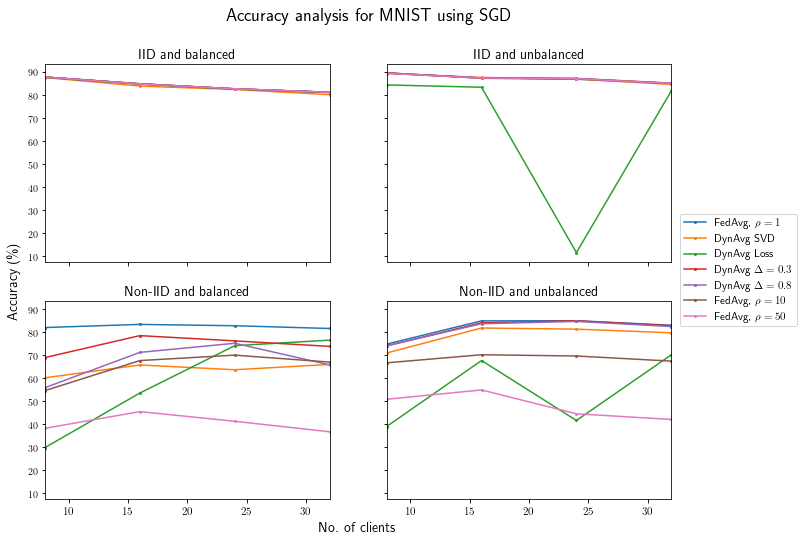

In [18]:
plot_results(
    mnist_res,
    'test_acc',
    xlabel='No. of clients',
    ylabel='Accuracy (\%)',
    suptitle='Accuracy analysis for MNIST using SGD',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-mnist-sgd-acc.png', dpi=500, format='png')

### Generalization gap

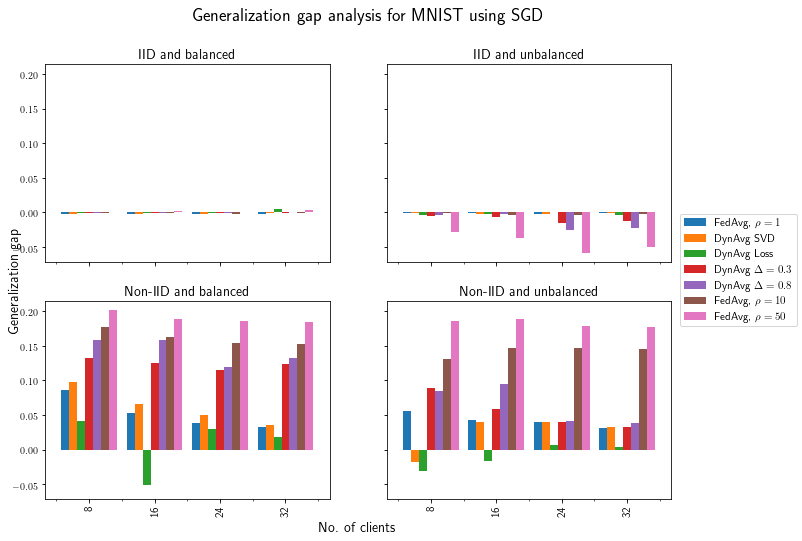

In [19]:
plot_results(
    mnist_res,
    'gen_gap',
    xlabel='No. of clients',
    ylabel='Generalization gap',
    suptitle='Generalization gap analysis for MNIST using SGD',
    titles=titles,
    kind='bar'
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-mnist-sgd-gen-gap.png', dpi=500, format='png')

### Packet size

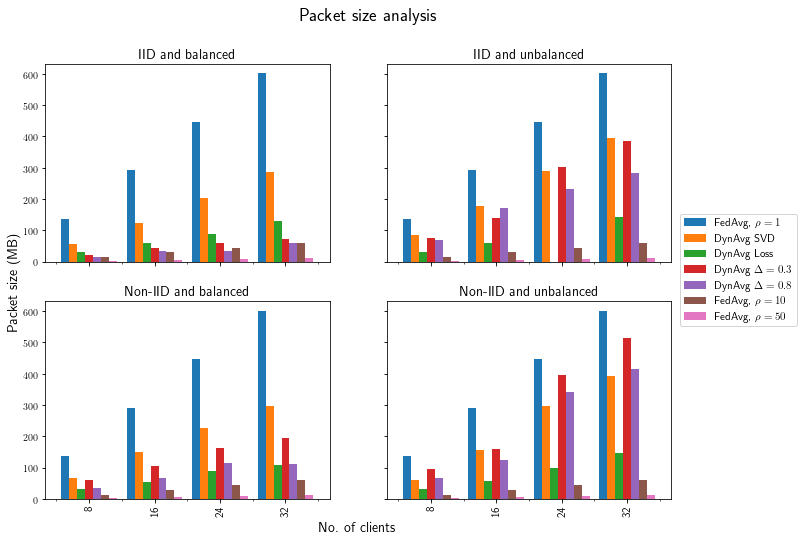

In [20]:
plot_results(
    mnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle='Packet size analysis',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-mnist-sgd-pkt.png', dpi=500, format='png')

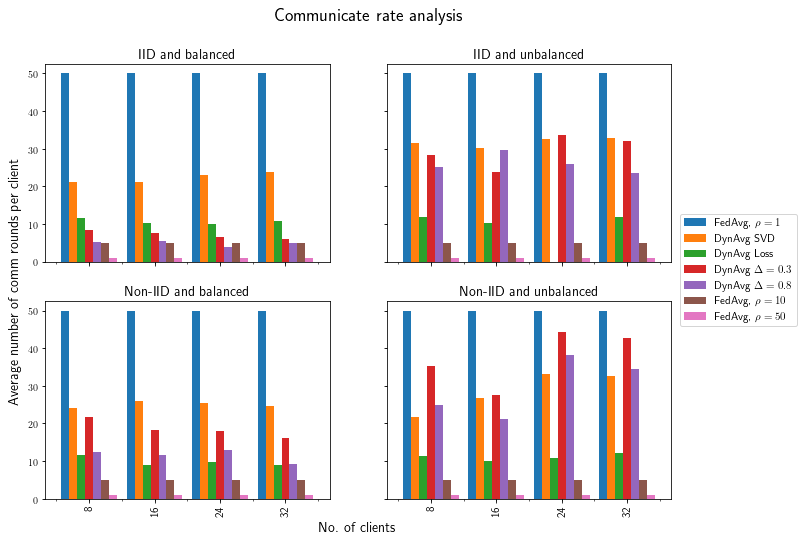

In [21]:
plot_results(
    mnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle='Communicate rate analysis',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-mnist-sgd-cr.png', dpi=500, format='png')

## Fashion-MNIST - SGD

In [22]:
fmnist_res, fmnist_q = generate_all_pivots(nn_fmnist, metrics=metrics)

### Wall time

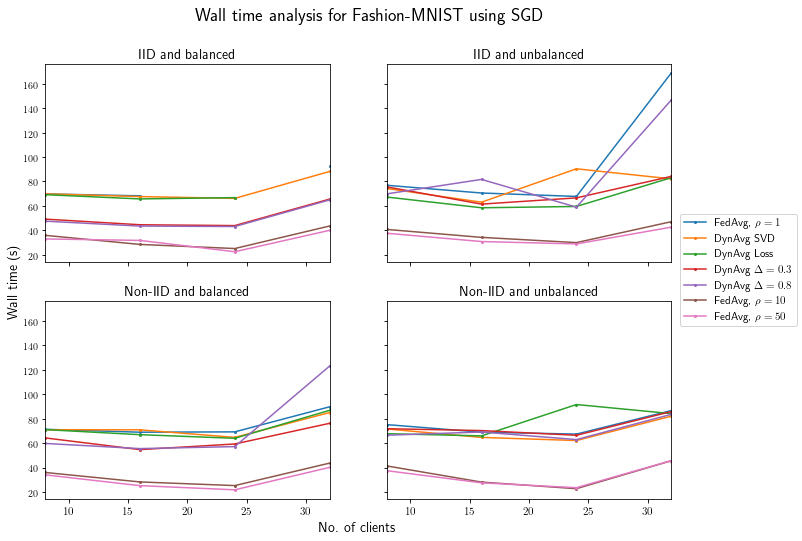

In [23]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    fmnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle='Wall time analysis for Fashion-MNIST using SGD',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-fmnist-sgd-time.png', dpi=500, format='png')

### Accuracy

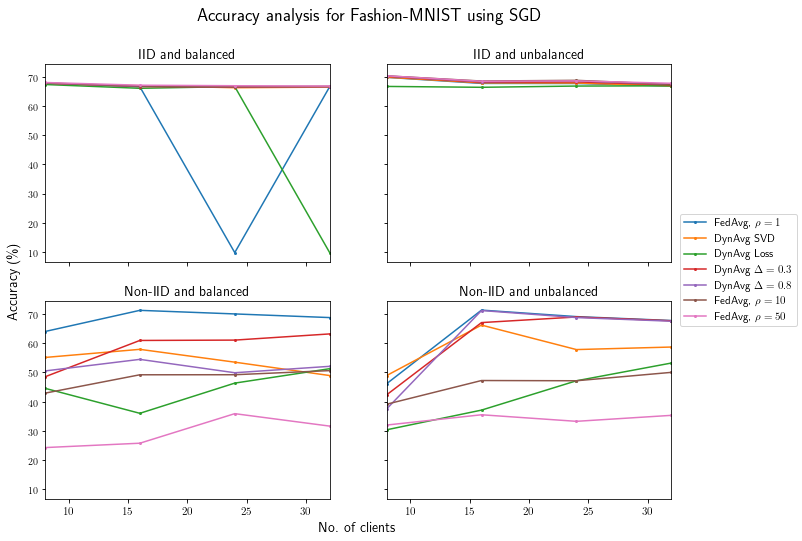

In [24]:
plot_results(
    fmnist_res,
    'test_acc',
    xlabel='No. of clients',
    ylabel='Accuracy (\%)',
    suptitle='Accuracy analysis for Fashion-MNIST using SGD',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-fmnist-sgd-acc.png', dpi=500, format='png')

### Generalization gap

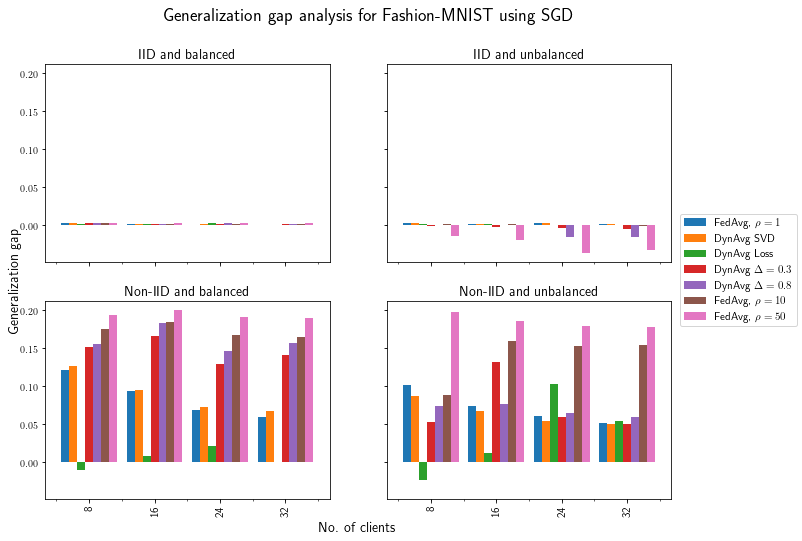

In [25]:
plot_results(
    fmnist_res,
    'gen_gap',
    xlabel='No. of clients',
    ylabel='Generalization gap',
    suptitle='Generalization gap analysis for Fashion-MNIST using SGD',
    titles=titles,
    kind='bar'
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-fmnist-sgd-gen-gap.png', dpi=500, format='png')

### Packet size

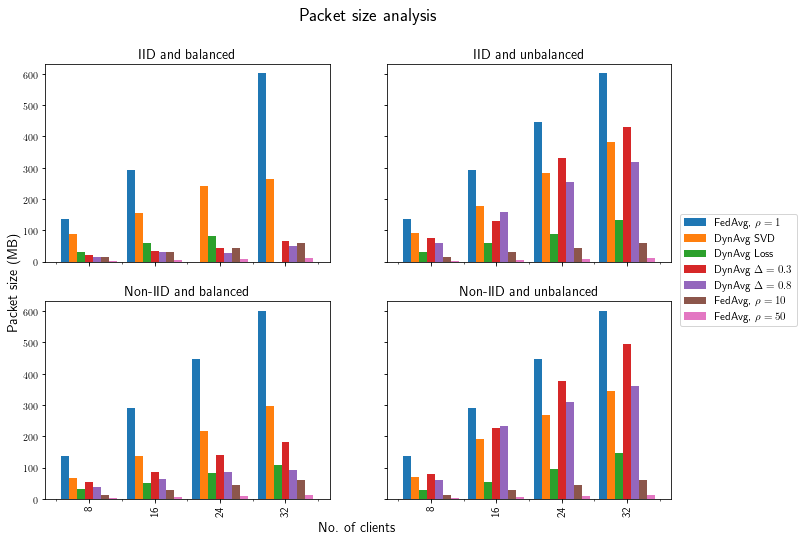

In [26]:
plot_results(
    fmnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle='Packet size analysis',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-fmnist-sgd-pkt.png', dpi=500, format='png')

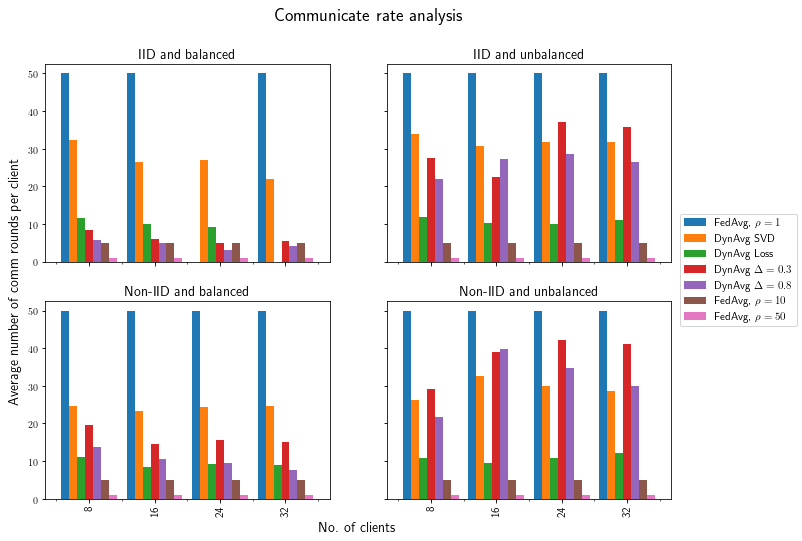

In [27]:
plot_results(
    fmnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle='Communicate rate analysis',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-fmnist-sgd-cr.png', dpi=500, format='png')

## MNIST - Adam

In [28]:
drop_query = 'delta_threshold == 0.0  and comm_mode == 3'
adam_results = adam_results.drop(adam_results.query(drop_query).index).reset_index(drop=True)

In [29]:
nn_mnist = adam_results.query(
    "dataset == 'mnist' and model_type=='nn1' and n_clients < 64"
    " and optimizer == 'adam'"
)
nn_fmnist = adam_results.query(
    "dataset == 'fashion-mnist' and model_type=='nn1' and n_clients < 64"
    " and optimizer == 'adam'"
)

In [30]:
mnist_res, mnist_q = generate_all_pivots(nn_mnist, metrics=metrics)

### Wall time

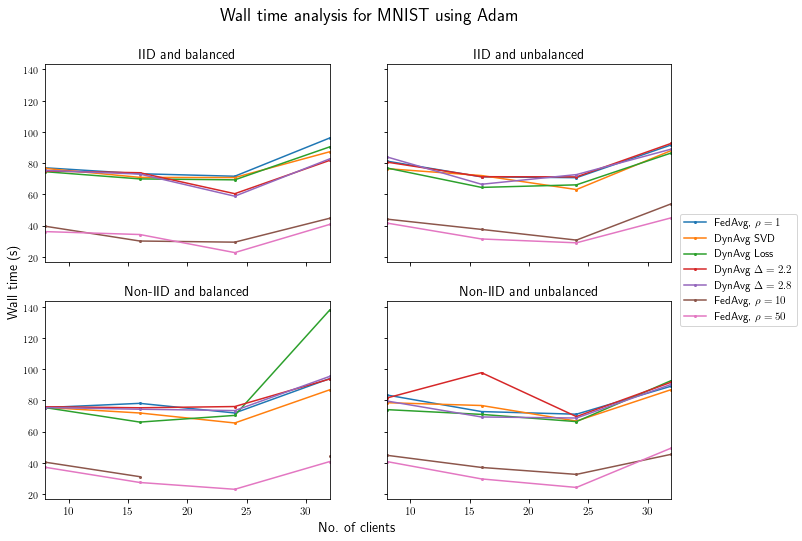

In [31]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    mnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle='Wall time analysis for MNIST using Adam',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-mnist-adam-time.png', dpi=500, format='png')

### Accuracy

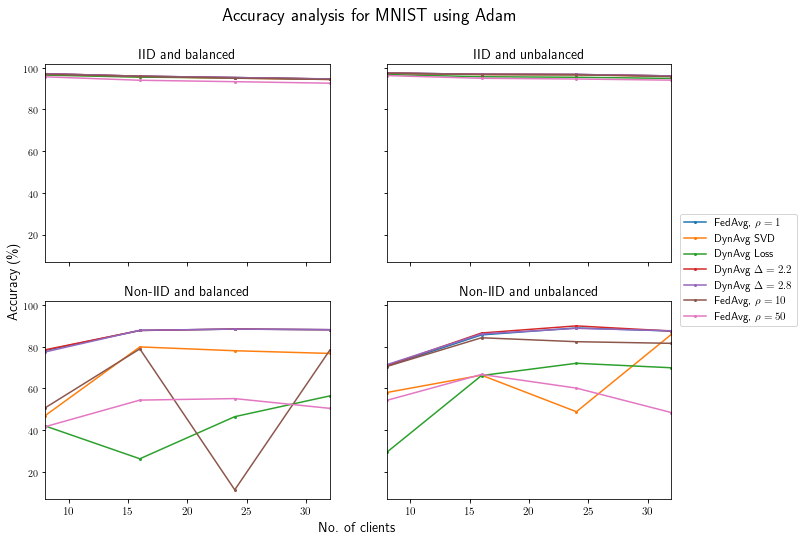

In [32]:
plot_results(
    mnist_res,
    'test_acc',
    xlabel='No. of clients',
    ylabel='Accuracy (\%)',
    suptitle='Accuracy analysis for MNIST using Adam',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-mnist-adam-acc.png', dpi=500, format='png')

### Generalization gap

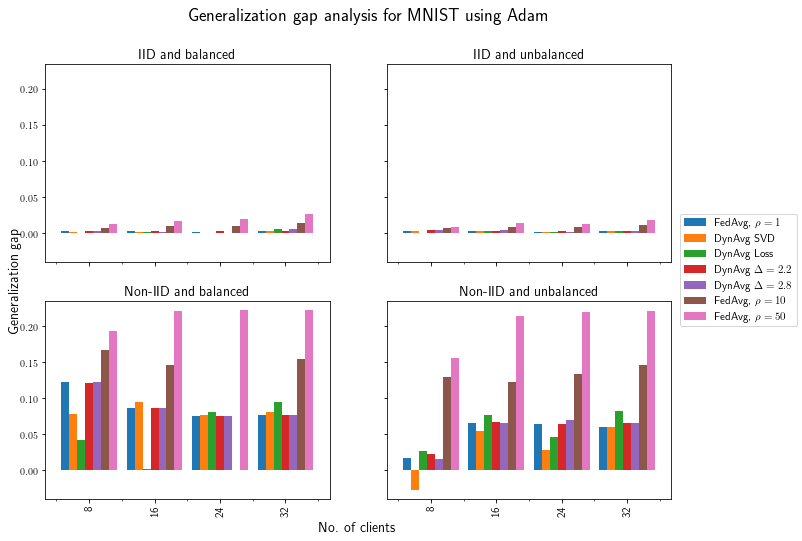

In [33]:
plot_results(
    mnist_res,
    'gen_gap',
    xlabel='No. of clients',
    ylabel='Generalization gap',
    suptitle='Generalization gap analysis for MNIST using Adam',
    titles=titles,
    kind='bar'
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-mnist-adam-gen-gap.png', dpi=500, format='png')

### Packet size

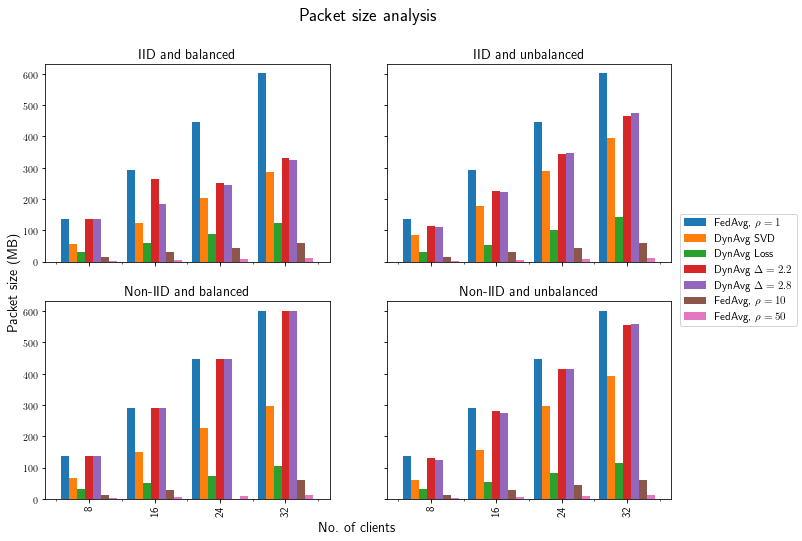

In [34]:
plot_results(
    mnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle='Packet size analysis',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-mnist-adam-pkt.png', dpi=500, format='png')

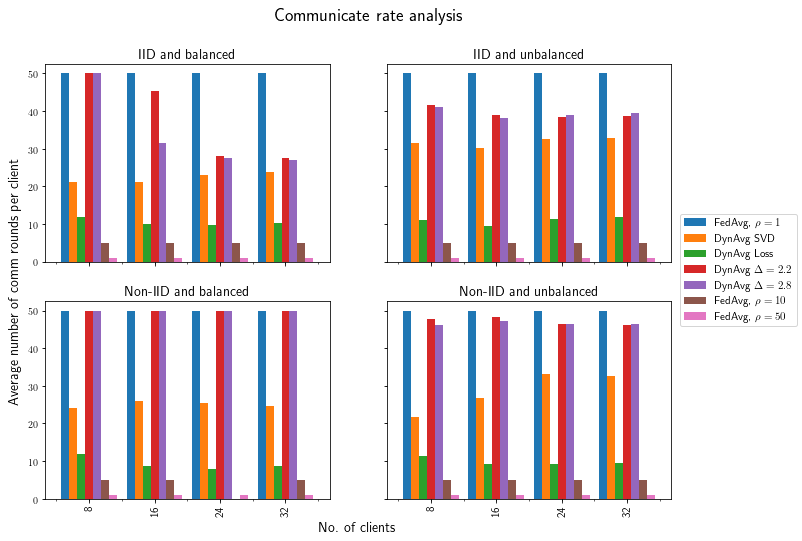

In [35]:
plot_results(
    mnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle='Communicate rate analysis',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-mnist-adam-cr.png', dpi=500, format='png')

## Fashion-MNIST - Adam

In [36]:
fmnist_res, fmnist_q = generate_all_pivots(nn_fmnist, metrics=metrics)

### Wall time

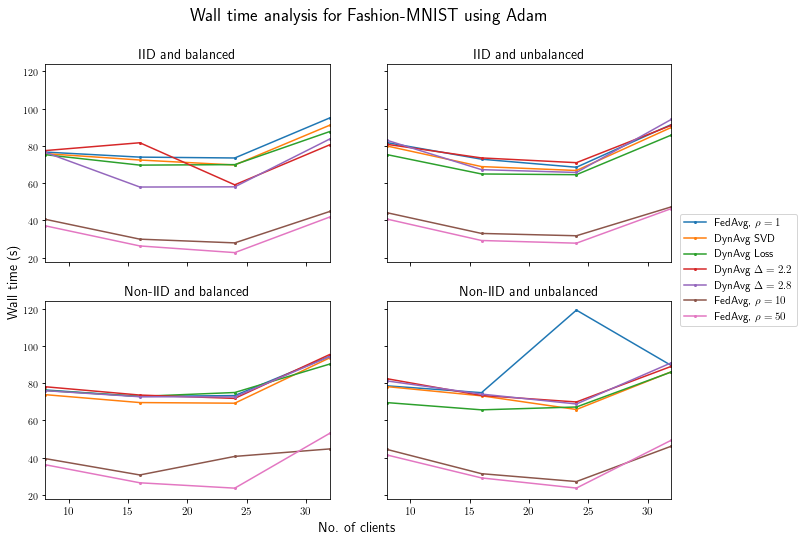

In [37]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    fmnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle='Wall time analysis for Fashion-MNIST using Adam',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-fmnist-adam-time.png', dpi=500, format='png')

### Accuracy

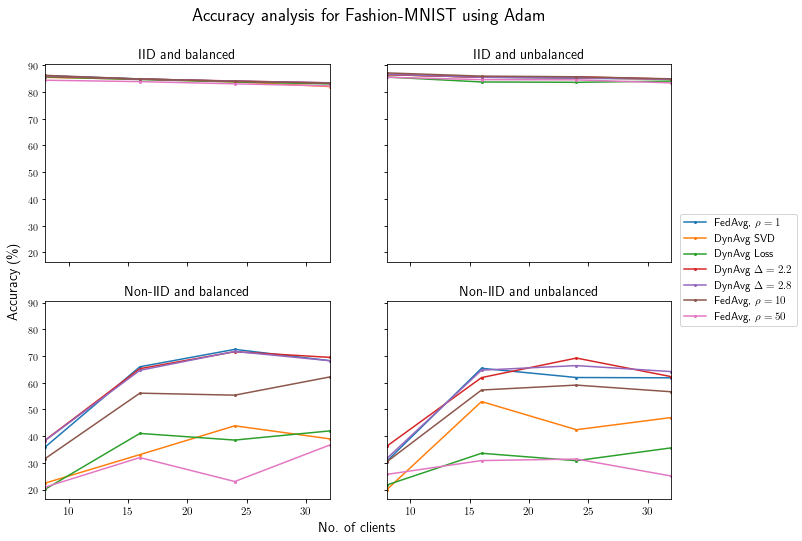

In [38]:
plot_results(
    fmnist_res,
    'test_acc',
    xlabel='No. of clients',
    ylabel='Accuracy (\%)',
    suptitle='Accuracy analysis for Fashion-MNIST using Adam',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-fmnist-adam-acc.png', dpi=500, format='png')

### Generalization gap

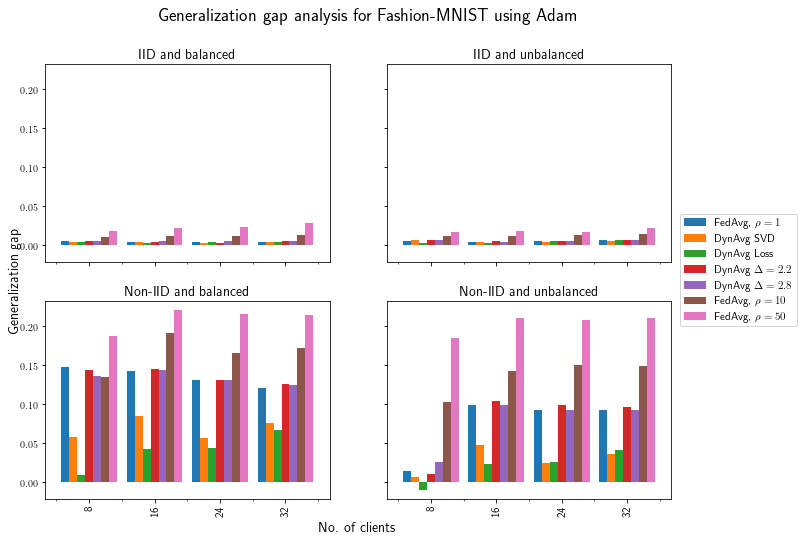

In [39]:
plot_results(
    fmnist_res,
    'gen_gap',
    xlabel='No. of clients',
    ylabel='Generalization gap',
    suptitle='Generalization gap analysis for Fashion-MNIST using Adam',
    titles=titles,
    kind='bar'
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-fmnist-adam-gen-gap.png', dpi=500, format='png')

### Packet size

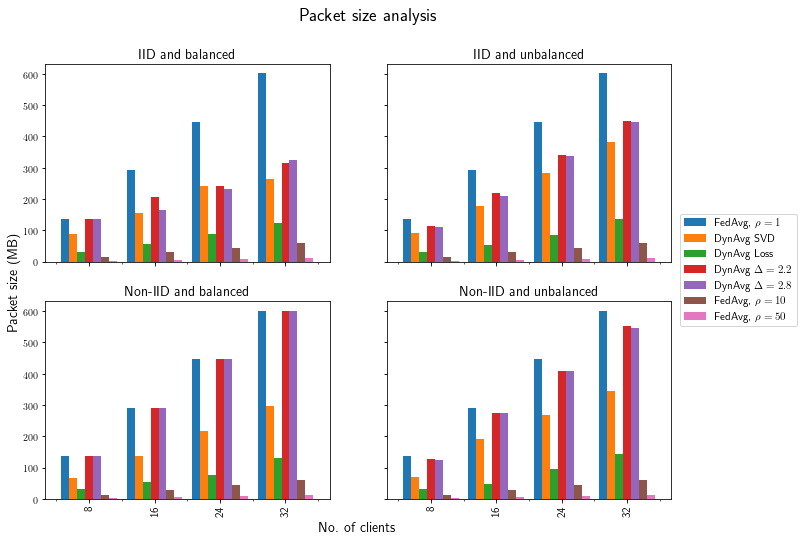

In [40]:
plot_results(
    fmnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle='Packet size analysis',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-fmnist-adam-pkt.png', dpi=500, format='png')

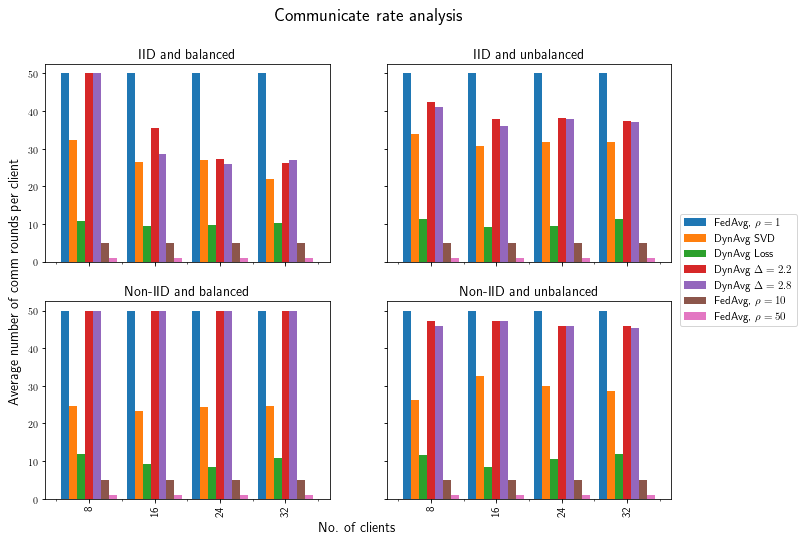

In [41]:
plot_results(
    fmnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle='Communicate rate analysis',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-fmnist-adam-cr.png', dpi=500, format='png')

In [42]:
mnist_fed = pd.read_csv("../data/output/mnist-pkt-size.csv")
# mnist_avg = pd.read_csv("../data/output/mnist-avg.csv")

FileNotFoundError: [Errno 2] File b'../data/output/mnist-pkt-size.csv' does not exist: b'../data/output/mnist-pkt-size.csv'

In [ ]:
mnist_fed.head()

In [ ]:
# mnist_avg.head()

#### IID and balanced

##### Time

In [ ]:
ib_query = 'NONIID == 0 and UNBALANCED == 0'
t_ib_merged = performance_pivot(mnist_fed, ib_query, 'TIME', columns=columns, xlabel=xlabel)
t_ib_merged

##### Accuracy

In [ ]:
acc_ib_merged = performance_pivot(mnist_fed, ib_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_ib_merged

In [ ]:
# ax = acc_ib_merged_piv.plot(figsize=(12, 8))
# ax.set_ylabel('Wall time (s)', fontdict=dict(fontsize=12))
# ax.set_xlabel('No. of workers', fontdict=dict(fontsize=12))

#### Non-IID and Balanced

In [ ]:
nb_query = 'NONIID == 1 and UNBALANCED == 0'

###### Time

In [ ]:
t_nb_merged = performance_pivot(mnist_fed, nb_query, 'TIME', columns=columns, xlabel=xlabel)
t_nb_merged

##### Accuracy

In [ ]:
acc_nb_merged = performance_pivot(mnist_fed, nb_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_nb_merged

#### Non-IID and Unbalanced

##### Time

In [ ]:
nu_query = 'NONIID == 1 and UNBALANCED == 1'

In [ ]:
t_nu_merged = performance_pivot(mnist_fed, nu_query, 'TIME', columns=columns, xlabel=xlabel)
t_nu_merged

##### Accuracy

In [ ]:
acc_nu_merged = performance_pivot(mnist_fed, nu_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_nu_merged

#### IID and Unbalanced

##### Time

In [ ]:
iu_query = 'NONIID == 0 and UNBALANCED == 1'

In [ ]:
t_iu_merged = performance_pivot(mnist_fed, iu_query, 'TIME', columns=columns, xlabel=xlabel)
t_iu_merged

##### Accuracy

In [ ]:
acc_iu_merged = performance_pivot(mnist_fed, iu_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_iu_merged

#### Packet size

In [ ]:
pkt_size_piv = (
    mnist_fed.query("AGG_MODE == 1")
    .pivot_table(
        values="PKT_SIZE", index="N_WORKERS", columns=["COMM_MODE", "COMM_PERIOD"]
    )
)
pkt_size_piv.columns = [
    r'FedAvg, $\rho=1$', r'FedAvg, $\rho=10$', r'FedAvg, $\rho=20$',
    r'FedAvg, $\rho=50$', r'FedAvg, $\rho=100$', r'DynAvg SVD', r'DynAvg Loss'
]
pkt_size_piv = pkt_size_piv.loc[:, columns]
pkt_size_piv.index = pkt_size_piv.index - 1

In [ ]:
pkt_size_piv

### Wall time analysis

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# IID and Balanced
t_ib_merged.plot(ax=axes[0, 0])
# axes[0, 0].set_ylabel('Wall time (s)', fontdict=dict(fontsize=12))
axes[0, 0].set_title('IID and Balanced', fontdict=dict(fontsize=14))
axes[0, 0].legend().remove()

# Non IID and Balanced
t_nb_merged.plot(ax=axes[0, 1])
axes[0, 1].set_title('Non-IID and Balanced', fontdict=dict(fontsize=14))
axes[0, 1].legend().remove()

# IID and Unbalanced
t_iu_merged.plot(ax=axes[1, 0])
axes[1, 0].set_title('IID and Unbalanced', fontdict=dict(fontsize=14))
axes[1, 0].set_xlabel('')
axes[1, 0].legend().remove()

# Non IID and Unbalanced
t_nu_merged.plot(ax=axes[1, 1])
axes[1, 1].set_title('Non-IID and Unbalanced', fontdict=dict(fontsize=14))
axes[1, 1].set_xlabel('')

handles, labels = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend().remove()
# fig.legend(handles, labels, loc='upper right', fontsize=12)
fig.legend(handles, labels, loc=7, fontsize=11)
# fig2.tight_layout()
fig.subplots_adjust(right=0.85)

plt.setp(axes[1, 0].get_xticklabels(), fontsize=11)
plt.setp(axes[1, 1].get_xticklabels(), fontsize=11)
plt.setp(axes[0, 1].get_yticklabels(), fontsize=11)
plt.setp(axes[1, 1].get_yticklabels(), fontsize=11)
plt.ylabel('Wall time (s)', fontdict=dict(fontsize=14))
plt.xlabel('No. of clients', fontdict=dict(fontsize=14))
plt.suptitle('Wall time analysis for MNIST', fontsize=18)
plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')

### Accuracy analysis

In [ ]:
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
# add a big axes, hide frame
fig2.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# IID and balanced
acc_ib_merged.plot(ax=axes2[0, 0])
axes2[0, 0].set_title('IID and Balanced', fontdict=dict(fontsize=14))
axes2[0, 0].legend().remove()

# Non-IID and balanced
acc_nb_merged.plot(ax=axes2[0, 1])
axes2[0, 1].set_title('Non-IID and Balanced', fontdict=dict(fontsize=14))
axes2[0, 1].legend().remove()

# IID and Unbalanced
acc_iu_merged.plot(ax=axes2[1, 0])
axes2[1, 0].set_title('IID and Unbalanced', fontdict=dict(fontsize=14))
axes2[1, 0].set_xlabel('')
axes2[1, 0].legend().remove()

# Non-IID and Unbalanced
acc_nu_merged.plot(ax=axes2[1, 1])
axes2[1, 1].set_title('Non-IID and Unbalanced', fontdict=dict(fontsize=14))
axes2[1, 1].set_xlabel('')

handles, labels = axes2[1, 1].get_legend_handles_labels()
axes2[1, 1].legend().remove()
# fig2.legend(handles, labels, loc='upper right', fontsize=12, bbox_to_anchor=(0.95, 0.83), borderaxespad=0)
fig2.legend(handles, labels, loc=7, fontsize=11)
# fig2.tight_layout()
fig2.subplots_adjust(right=0.85)
plt.setp(axes2[1, 0].get_xticklabels(), fontsize=11)
plt.setp(axes2[1, 1].get_xticklabels(), fontsize=11)
plt.setp(axes2[0, 1].get_yticklabels(), fontsize=11)
plt.setp(axes2[1, 1].get_yticklabels(), fontsize=11)
plt.ylabel('Accuracy (\%)', fontdict=dict(fontsize=14))
plt.xlabel('No. of clients', fontdict=dict(fontsize=14))
plt.suptitle(r'Accuracy analysis for MNIST', fontsize=18)
plt.savefig('../reports/figures/accuracy-analysis.png', dpi=500, format='png')

### Fashion-MNIST

In [ ]:
f_mnist_fed = pd.read_csv("../data/output/fmnist-pkt-size.csv")
# mnist_avg = pd.read_csv("../data/output/mnist-avg.csv")
f_mnist_fed = f_mnist_fed.loc[~f_mnist_fed.isnull().any(axis=1)]

In [ ]:
f_mnist_fed.head()

In [ ]:
# mnist_avg.head()

#### IID and balanced

##### Time

In [ ]:
ib_query = 'NONIID == 0 and UNBALANCED == 0'
t_ib_merged_f = performance_pivot(f_mnist_fed, ib_query, 'TIME', columns=columns, xlabel=xlabel)
t_ib_merged_f

##### Accuracy

In [ ]:
acc_ib_merged_f = performance_pivot(f_mnist_fed, ib_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_ib_merged_f

#### Non-IID and Balanced

In [ ]:
nb_query = 'NONIID == 1 and UNBALANCED == 0'

###### Time

In [ ]:
t_nb_merged_f = performance_pivot(f_mnist_fed, nb_query, 'TIME', columns=columns, xlabel=xlabel)
t_nb_merged_f

##### Accuracy

In [ ]:
acc_nb_merged_f = performance_pivot(f_mnist_fed, nb_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_nb_merged_f

#### Non-IID and Unbalanced

##### Time

In [ ]:
nu_query = 'NONIID == 1 and UNBALANCED == 1'

In [ ]:
t_nu_merged_f = performance_pivot(f_mnist_fed, nu_query, 'TIME', columns=columns, xlabel=xlabel)
t_nu_merged_f

##### Accuracy

In [ ]:
acc_nu_merged_f = performance_pivot(f_mnist_fed, nu_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_nu_merged_f

#### IID and Unbalanced

##### Time

In [ ]:
iu_query = 'NONIID == 0 and UNBALANCED == 1'

In [ ]:
t_iu_merged_f = performance_pivot(f_mnist_fed, iu_query, 'TIME', columns=columns, xlabel=xlabel)
t_iu_merged_f

##### Accuracy

In [ ]:
acc_iu_merged_f = performance_pivot(f_mnist_fed, iu_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_iu_merged_f

#### Packet size

In [ ]:
pkt_size_piv_f = (
    f_mnist_fed.query("AGG_MODE == 1")
    .pivot_table(
        values="PKT_SIZE", index="N_WORKERS", columns=["COMM_MODE", "COMM_PERIOD"]
    )
)
pkt_size_piv_f.columns = [
    r'FedAvg, $\rho=1$', r'FedAvg, $\rho=10$', r'FedAvg, $\rho=20$',
    r'FedAvg, $\rho=50$', r'FedAvg, $\rho=100$', r'DynAvg SVD', r'DynAvg Loss'
]
pkt_size_piv_f = pkt_size_piv_f.loc[:, columns]
pkt_size_piv_f.index = pkt_size_piv_f.index - 1

In [ ]:
pkt_size_piv_f

### Wall time analysis

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# IID and Balanced
t_ib_merged_f.plot(ax=axes[0, 0])
axes[0, 0].set_title('IID and Balanced', fontdict=dict(fontsize=14))
axes[0, 0].legend().remove()

# Non IID and Balanced
t_nb_merged_f.plot(ax=axes[0, 1])
axes[0, 1].set_title('Non-IID and Balanced', fontdict=dict(fontsize=14))
axes[0, 1].legend().remove()

# IID and Unbalanced
t_iu_merged_f.plot(ax=axes[1, 0])
axes[1, 0].set_title('IID and Unbalanced', fontdict=dict(fontsize=14))
axes[1, 0].set_xlabel('')
axes[1, 0].legend().remove()

# Non IID and Unbalanced
t_nu_merged_f.plot(ax=axes[1, 1])
axes[1, 1].set_title('Non-IID and Unbalanced', fontdict=dict(fontsize=14))
axes[1, 1].set_xlabel('')

handles, labels = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend().remove()
# fig.legend(handles, labels, loc='upper right', fontsize=12)
fig.legend(handles, labels, loc=7, fontsize=11)
# fig2.tight_layout()
fig.subplots_adjust(right=0.85)

plt.setp(axes[1, 0].get_xticklabels(), fontsize=11)
plt.setp(axes[1, 1].get_xticklabels(), fontsize=11)
plt.setp(axes[0, 1].get_yticklabels(), fontsize=11)
plt.setp(axes[1, 1].get_yticklabels(), fontsize=11)
plt.ylabel('Wall time (s)', fontdict=dict(fontsize=14))
plt.xlabel('No. of clients', fontdict=dict(fontsize=14))
plt.suptitle('Wall time analysis for Fashion-MNIST', fontsize=18)
plt.savefig('../reports/figures/time-analysis-fmnist.png', dpi=500, format='png')

### Accuracy analysis

In [ ]:
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
# add a big axes, hide frame
fig2.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# IID and balanced
acc_ib_merged_f.plot(ax=axes2[0, 0])
axes2[0, 0].set_title('IID and Balanced', fontdict=dict(fontsize=14))
axes2[0, 0].legend().remove()

# Non-IID and balanced
acc_nb_merged_f.plot(ax=axes2[0, 1])
axes2[0, 1].set_title('Non-IID and Balanced', fontdict=dict(fontsize=14))
axes2[0, 1].legend().remove()

# IID and Unbalanced
acc_iu_merged_f.plot(ax=axes2[1, 0])
axes2[1, 0].set_title('IID and Unbalanced', fontdict=dict(fontsize=14))
axes2[1, 0].set_xlabel('')
axes2[1, 0].legend().remove()

# Non-IID and Unbalanced
acc_nu_merged_f.plot(ax=axes2[1, 1])
axes2[1, 1].set_title('Non-IID and Unbalanced', fontdict=dict(fontsize=14))
axes2[1, 1].set_xlabel('')
# axes2[1, 1].legend('')

handles, labels = axes2[1, 1].get_legend_handles_labels()
axes2[1, 1].legend().remove()
# fig2.legend(handles, labels, loc='upper right', fontsize=12)
fig2.legend(handles, labels, loc=7, fontsize=11)
# fig2.tight_layout()
fig2.subplots_adjust(right=0.85)

plt.setp(axes2[1, 0].get_xticklabels(), fontsize=11)
plt.setp(axes2[1, 1].get_xticklabels(), fontsize=11)
plt.setp(axes2[0, 1].get_yticklabels(), fontsize=11)
plt.setp(axes2[1, 1].get_yticklabels(), fontsize=11)
plt.ylabel('Accuracy (\%)', fontdict=dict(fontsize=14))
plt.xlabel('No. of clients', fontdict=dict(fontsize=14))
plt.suptitle(r'Accuracy analysis for Fashion-MNIST', fontsize=18)
plt.savefig('../reports/figures/accuracy-analysis-fashion-mnist.png', dpi=500, format='png')

### Packet size analysis

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# Mnist
pkt_size_piv.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('MNIST', fontdict=dict(fontsize=16))
axes[0].set_xlabel('')
axes[0].legend().remove()
# Fashion Mnist
pkt_size_piv_f.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Fashion-MNIST', fontdict=dict(fontsize=16))
axes[1].set_xlabel('')
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend().remove()
# fig.legend(handles, labels, loc='upper right', prop={'size': 12})
fig.legend(handles, labels, loc='lower center', fontsize=11, ncol=4)
# fig2.tight_layout()
fig.subplots_adjust(bottom=0.2)


plt.suptitle('Packet size analysis', fontsize=18)
plt.xlabel('No. of clients', fontdict=dict(fontsize=14))
plt.ylabel('Packet size (MB)', fontdict=dict(fontsize=14))
plt.setp(axes[0].get_xticklabels(), ha='center', rotation=0, fontsize=12)
plt.setp(axes[1].get_xticklabels(), ha='center', rotation=0, fontsize=12)
plt.setp(axes[0].get_yticklabels(), fontsize=12)
plt.setp(axes[1].get_yticklabels(), fontsize=12)
plt.savefig('../reports/figures/packet-size-analysis.png', dpi=500, format='png')